# CCS reception facility location problem

In [1]:
import xpress as xp
import pandas as pd
import time
import matplotlib.pyplot as plt

xp.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
xp.controls.outputlog = 0

Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')


# Locating carbon capture reception facilities along major trade routes

Onboard carbon capture and storage (CCS) is one potential way forward for reducing CO2 emission from shipping. Carbon is extracted from the ship´s exhaust gases, and stored onboard until these tanks can be emptied at a CCS reception facility, and further transported to the long term storage site.

The CCS tanks will require space onboard, and ultimately reduce the cargo carrier capacity of the vessel. This call for frequent unloading of CO2, and many facilities. On the other hand, such facilities are costly to establish and operate, calling for few facilities. Thus, we need to strike a balance.

In the basis model, we capture a vessel sailing along a fixed route with varying inter-port distances. The main decision variable is to determine the optimal location of reception facility points. 

### Sets

$P$ Set of ports (nodes), indexed by $p$

$A$ Set of sailings (arcs) between bunkering ports, index by $a$, $(i,j)$ 

### Parameters

$C^R$ - Cost of establishing the bunkering terminal at the port (MU)

$C^O$ - Lost opportunity cost due to the volume of fuel occupying space that could have been used for cargo

$d_{ij}$ - Distance between port $i$ and port $j$

### Variables

$x_p$ - 1 if a reception facility is established in port $p$, 0 otherwise

$y_{ij}$ - 1 if the ship sails from $i$ to $j$ before unloading CO2, 0 otherwise

$z$ - The longest distance sailed before being able to unload CO2

### Objective function

$$ min \sum_{p\in P} C^r x_i + C^{loc} z$$

### Constraints

$$\sum_{s,j\in P/\{s\}} = 1$$

$$\sum_{j\in P/\{e\},e} = 1$$

$$\sum_{(i,j)\in A} y_{i,j} <= x_i, a\in A$$

$$\sum_{(i,j)\in A} y_{i,j} - \sum_{(j,k)\in A} y_{j,k} = 0, j\in P/\{s,e\}$$

$$d_{ij} y_{ij} <= z$$

$$x_{p} \in \{0,1\}, p\in P$$

$$y_{ij} \in \{0,1\}, (ij)\in A$$

In [1]:
def ccs_model(Cr,Cloc,legs):

    nP = len(legs)+1
    P = [p for p in range(nP)]
    A = [(i,j) for i in range(nP) for j in range(i+1,nP)]
    
    d = {a:sum(legs[a[0]:a[1]]) for a in A}
    
    s = P[0] # Start node
    e = P[-1] # End node
    
    m = xp.problem()

    x = [xp.var (vartype = xp.binary, name='x{0}'.format (p)) for p in P]
    y = {a: xp.var (vartype = xp.binary, name='y{0}{1}'.format (a[0],a[1])) for a in A}
    z = xp.var()
    m.addVariable(x,y,z)
    
    # Objective: Min ccs facility establishment cost and lost opportunity cost
    m.setObjective(xp.Sum(Cr*x[i] for i in P) + Cloc*z, sense = xp.minimize)
    
    # Must start from node s and end in node e
    c1 = xp.Sum(y[(s,j)] for j in P if j is not s) == 1
    c2 = xp.Sum(y[(i,e)] for i in P if i is not e) == 1

    # CCS capturing sailings only between cc reception nodes
    # c3/c4 can be omitted if reception point not required in s/e
    c3 = [y[(a[0],a[1])] <= x[a[0]] for a in A]
    c4 = [y[(a[0],a[1])] <= x[a[1]] for a in A]

    c5 = [xp.Sum(y[(a[0],j)] for a in A if a[1] is j) \
          - xp.Sum(y[(j, a[1])] for a in A if a[0] is j) == 0 \
          for j in P if j not in [s,e]]

    c6 = [d[(a[0],a[1])] * y[(a[0],a[1])] <= z for (i,j) in A]

    m.addConstraint(c1,c2,c3,c4,c5,c6)
    
    m.solve()
    
    return m,x,y,z,d

In [31]:
def analyse_solution(m,x,y,z):

    totalCost = sum([Cr * m.getSolution(x[p]) for p in P]) + Cloc * m.getSolution(z)
    print(totalCost)
    ccs_loc = [int(m.getSolution(x[i])) for i in P]
    print(ccs_loc)
    sailings = {(a[0],a[1]):int(m.getSolution(y[(a[0],a[1])])) for a in A}
    print(sailings)
    long_dist = m.getSolution(z)
    print(long_dist)
    
    path = [k for k in sailings.keys() if sailings[k] is 1]
    return path


In [61]:
legs = [70,120,60,80,70]
Cr = 50
Cloc =2
    
nP = len(legs)+1
P = [p for p in range(nP)]
A = [(i,j) for i in range(nP) for j in range(i+1,nP)]

m,x,y,z,d = ccs_model(Cr,Cloc,legs)
path = analyse_solution(m,x,y,z)


530.0
[1, 0, 1, 0, 1, 1]
{(0, 1): 1, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (1, 2): 1, (1, 3): 0, (1, 4): 0, (1, 5): 0, (2, 3): 0, (2, 4): 1, (2, 5): 0, (3, 4): 0, (3, 5): 0, (4, 5): 1}
140.00000000000003


In [62]:
path

[(0, 1), (1, 2), (2, 4), (4, 5)]

In [63]:
nP = len(legs)+1
P = [p for p in range(nP)]
A = [(i,j) for i in range(nP) for j in range(i+1,nP)]
    
d = {a:sum(legs[a[0]:a[1]]) for a in A}
P

[0, 1, 2, 3, 4, 5]

In [64]:
import networkx as nx
import numpy as np
import random as rnd

{(0, 1): Text(0.5, -3.0, '70'),
 (0, 2): Text(1.0, -7.5, '190'),
 (0, 3): Text(1.5, 10.0, '250'),
 (0, 4): Text(2.0, -7.5, '330'),
 (0, 5): Text(3.0, 0.0, '400'),
 (1, 2): Text(1.5, -10.5, '120'),
 (1, 3): Text(2.0, 7.0, '180'),
 (1, 4): Text(2.5, -10.5, '260'),
 (1, 5): Text(3.5, -3.0, '330'),
 (2, 3): Text(2.5, 2.5, '60'),
 (2, 4): Text(3.0, -15.0, '140'),
 (2, 5): Text(4.0, -7.5, '210'),
 (3, 4): Text(3.5, 2.5, '80'),
 (3, 5): Text(4.5, 10.0, '150'),
 (4, 5): Text(5.0, -7.5, '70')}

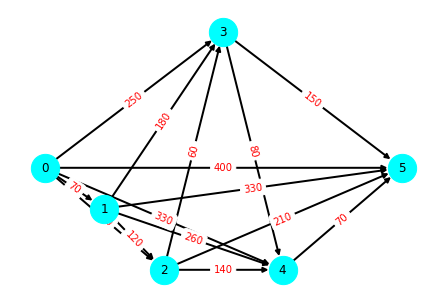

In [65]:
G = nx.DiGraph()
arcsData = [(a[0],a[1],d[a]) for a in A]
G.add_weighted_edges_from(arcsData)

l = len(P)
pos = {p: np.array((p,rnd.randint(-5,5)*(l+1-p))) for p in P[1:-1]}
pos[0] = np.array((0,0))
pos[l-1] = np.array((l,0))

options = {'node_color': 'cyan','node_size': 800,'width': 2}

nx.draw(G,pos, with_labels=True, **options)
dist = {(e[0],e[1]):str(G.edges[e[0],e[1]]['weight']) for e in list(G.edges())}
nx.draw_networkx_edge_labels(G,pos,edge_labels=dist,font_color='red')

## The optimal solution

{(0, 1): Text(0.5, -3.0, '70'),
 (0, 2): Text(1.0, -7.5, '190'),
 (0, 3): Text(1.5, 10.0, '250'),
 (0, 4): Text(2.0, -7.5, '330'),
 (0, 5): Text(3.0, 0.0, '400'),
 (1, 2): Text(1.5, -10.5, '120'),
 (1, 3): Text(2.0, 7.0, '180'),
 (1, 4): Text(2.5, -10.5, '260'),
 (1, 5): Text(3.5, -3.0, '330'),
 (2, 3): Text(2.5, 2.5, '60'),
 (2, 4): Text(3.0, -15.0, '140'),
 (2, 5): Text(4.0, -7.5, '210'),
 (3, 4): Text(3.5, 2.5, '80'),
 (3, 5): Text(4.5, 10.0, '150'),
 (4, 5): Text(5.0, -7.5, '70')}

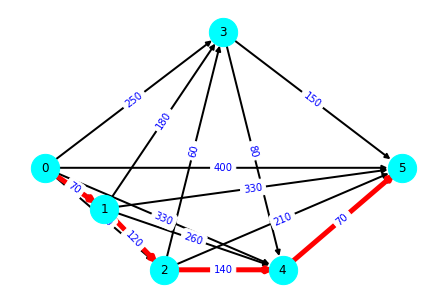

In [66]:
nx.draw(G,pos, with_labels=True, **options)
#shortPath = [(path[i],path[i-1]) for i in range(len(path)-1,0,-1)]
nx.draw_networkx_edges(G,pos,edgelist=path,width=5,edge_color='red')
nx.draw_networkx_edge_labels(G,pos,edge_labels=dist,font_color='blue')